In [1]:
import os
import ast
import wfdb
import numpy as np
import pandas as pd

os.chdir("../..")
import utils

In [2]:
outputfolder = os.getcwd() + '/output/'
datafolder = os.getcwd() + '/datasets/PTB-XL/'
sampling_rate = 100
task = 'priority'
experiment_name = 'exp4'

In [3]:
data, raw_labels = utils.load_dataset(datafolder, sampling_rate=sampling_rate)
labels = utils.compute_label_aggregations(raw_labels, datafolder, task)
data, labels, Y, _ = utils.select_data(data, labels, task, 0, outputfolder+experiment_name+'/data/')

In [4]:
X_test = data[labels.strat_fold == 10]
y_test = Y[labels.strat_fold == 10]

X_val = data[labels.strat_fold == 9]
y_val = Y[labels.strat_fold == 9]

X_train = data[labels.strat_fold <= 8]
y_train = Y[labels.strat_fold <= 8]

n_classes = y_train.shape[1]

print(f"This experiment has {n_classes} classes")

This experiment has 43 classes


In [5]:
X_train_lead1 = X_train[:,:,0]
X_test_lead1 = X_test[:,:,0]
X_val_lead1 = X_val[:,:,0]

# Fit Simple ANN

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D
from keras.models import Sequential, Model
from keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score

In [8]:
ann_model = Sequential()
ann_model.add(Dense(50, activation='relu', input_shape=(1000,1)))
ann_model.add(Dense(50, activation='relu'))
ann_model.add(Dense(50, activation='relu'))
ann_model.add(Dense(50, activation='relu'))
ann_model.add(GlobalAveragePooling1D())
ann_model.add(Dense(n_classes, activation='sigmoid'))

In [8]:
from tensorflow.keras.utils import plot_model
tf.keras.utils.plot_model(
ann_model, to_file='model.png', show_shapes=False, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)



You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [9]:
ann_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=0.5),
                           tf.keras.metrics.Recall(name='Recall'),
                           tf.keras.metrics.Precision(name='Precision'),
                           tf.keras.metrics.AUC(num_thresholds=200, curve="ROC", name="AUC",
                                                multi_label=True, label_weights=None)])

In [10]:
ann_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 1000, 50)          100       
                                                                 
 dense_6 (Dense)             (None, 1000, 50)          2550      
                                                                 
 dense_7 (Dense)             (None, 1000, 50)          2550      
                                                                 
 dense_8 (Dense)             (None, 1000, 50)          2550      
                                                                 
 global_average_pooling1d_1   (None, 50)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_9 (Dense)             (None, 43)                2193      
                                                      

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', patience=3, verbose=1, min_delta=0, mode="max")

In [13]:
batchsize = 10
ann_model.fit(X_train_lead1, y_train, batch_size=batchsize, epochs=10, validation_data=(X_val_lead1,y_val), callbacks=[early_stopping])

Epoch 1/10
1708/1708 [==============================] - ETA: 0s - loss: 0.1183 - accuracy: 0.9612 - Recall: 0.4092 - Precision: 0.7299 - AUC: 0.5334

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000, 50)          650       
                                                                 
 dense_1 (Dense)             (None, 1000, 50)          2550      
                                                                 
 dense_2 (Dense)             (None, 1000, 50)          2550      
                                                                 
 dense_3 (Dense)             (None, 1000, 50)          2550      
                                                                 
 global_average_pooling1d (G  (None, 50)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_4 (Dense)             (None, 23)                1173      
                                                        

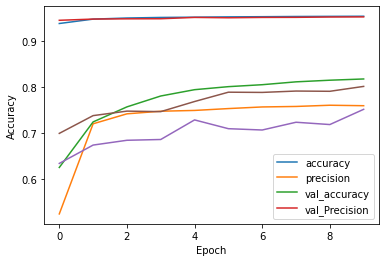

In [12]:
plt.plot(ann_model.history.history['accuracy'])
plt.plot(ann_model.history.history['Precision'])
plt.plot(ann_model.history.history['AUC'])
plt.plot(ann_model.history.history['val_accuracy'])
plt.plot(ann_model.history.history['val_Precision'])
plt.plot(ann_model.history.history['val_AUC'])
plt.legend(("accuracy","precision","auc", "val_accuracy","val_Precision", "val_auc"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

ann_model.summary()

In [13]:
ann_preds_test = ann_model.predict(X_test)

roc_auc_score(y_test, ann_preds_test)

68/68 [==============================] - 3s 37ms/step


0.8041964574403125

# Single lead simple ANN model

In [14]:
single_ann_model = Sequential()
single_ann_model.add(Dense(50, activation='relu', input_shape=(1000,1)))
single_ann_model.add(Dense(50, activation='relu'))
single_ann_model.add(Dense(50, activation='relu'))
single_ann_model.add(Dense(50, activation='relu'))
single_ann_model.add(GlobalAveragePooling1D())
single_ann_model.add(Dense(n_classes, activation='sigmoid'))

In [15]:
single_ann_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=0.5),
                           tf.keras.metrics.Recall(name='Recall'),
                           tf.keras.metrics.Precision(name='Precision'),
                           tf.keras.metrics.AUC(num_thresholds=200, curve="ROC", name="AUC",
                                                multi_label=True, label_weights=None)])

In [16]:
single_ann_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 1000, 50)          100       
                                                                 
 dense_6 (Dense)             (None, 1000, 50)          2550      
                                                                 
 dense_7 (Dense)             (None, 1000, 50)          2550      
                                                                 
 dense_8 (Dense)             (None, 1000, 50)          2550      
                                                                 
 global_average_pooling1d_1   (None, 50)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_9 (Dense)             (None, 23)                1173      
                                                      

In [29]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', patience=3, verbose=1, min_delta=0)

In [30]:
batchsize = 32
single_ann_model.fit(X_train_lead1, y_train, batch_size=batchsize, epochs=50, validation_data=(X_val_lead1,y_val), callbacks=[early_stopping])

Epoch 1/50
534/534 [==============================] - 40s 74ms/step - loss: 0.1646 - accuracy: 0.9455 - Recall: 0.2247 - Precision: 0.6733 - AUC: 0.7066 - val_loss: 0.1668 - val_accuracy: 0.9447 - val_Recall: 0.1944 - val_Precision: 0.6633 - val_AUC: 0.6908
Epoch 2/50
534/534 [==============================] - 41s 76ms/step - loss: 0.1645 - accuracy: 0.9456 - Recall: 0.2244 - Precision: 0.6771 - AUC: 0.7046 - val_loss: 0.1663 - val_accuracy: 0.9453 - val_Recall: 0.2397 - val_Precision: 0.6424 - val_AUC: 0.6897
Epoch 3/50
534/534 [==============================] - 40s 75ms/step - loss: 0.1646 - accuracy: 0.9456 - Recall: 0.2257 - Precision: 0.6762 - AUC: 0.7052 - val_loss: 0.1667 - val_accuracy: 0.9453 - val_Recall: 0.2374 - val_Precision: 0.6430 - val_AUC: 0.6905
Epoch 4/50
534/534 [==============================] - 44s 82ms/step - loss: 0.1646 - accuracy: 0.9455 - Recall: 0.2245 - Precision: 0.6745 - AUC: 0.7051 - val_loss: 0.1663 - val_accuracy: 0.9451 - val_Recall: 0.2113 - val_Prec

Text(0, 0.5, 'Accuracy')

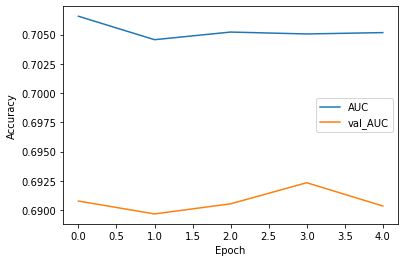

In [31]:
# plt.plot(single_ann_model.history.history['accuracy'])
# plt.plot(single_ann_model.history.history['Precision'])
plt.plot(single_ann_model.history.history['AUC'])
# plt.plot(single_ann_model.history.history['val_accuracy'])
# plt.plot(single_ann_model.history.history['val_Precision'])
plt.plot(single_ann_model.history.history['val_AUC'])
plt.legend(("AUC", "val_AUC"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


In [32]:
y_lead1_pred = single_ann_model.predict(X_test_lead1)

roc_auc_score(y_test, y_lead1_pred)

68/68 [==============================] - 2s 24ms/step


0.6998956730557921

## Run with early stopping now

In [30]:
single_ann_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=0.5),
                           tf.keras.metrics.Recall(name='Recall'),
                           tf.keras.metrics.Precision(name='Precision'),
                           tf.keras.metrics.AUC(num_thresholds=200, curve="ROC", name="AUC",
                                                multi_label=True, label_weights=None)])
single_ann_model.fit(X_train_lead1, y_train, batch_size=batchsize, epochs=50, validation_data=(X_val_lead1,y_val), callbacks=[early_stopping])


Epoch 1/50
1707/1709 [============================>.] - ETA: 0s - loss: 0.1666 - accuracy: 0.9447 - Recall: 0.2113 - Precision: 0.6621 - AUC: 0.6888

ValueError: in user code:

    File "c:\Users\agarw\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1852, in test_function  *
        return step_function(self, iterator)
    File "c:\Users\agarw\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1836, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\agarw\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1824, in run_step  **
        outputs = model.test_step(data)
    File "c:\Users\agarw\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1788, in test_step
        y_pred = self(x, training=False)
    File "c:\Users\agarw\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\agarw\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_2' (type Sequential).
    
    Input 0 of layer "dense_9" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 1000, 12)
    
    Call arguments received by layer 'sequential_2' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 1000, 12), dtype=float32)
      • training=False
      • mask=None


In [22]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', patience=3, verbose=1)

In [29]:
X_val_lead1.shape

(2146, 1000)

In [26]:
single_ann_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 1000, 50)          100       
                                                                 
 dense_10 (Dense)            (None, 1000, 50)          2550      
                                                                 
 dense_11 (Dense)            (None, 1000, 50)          2550      
                                                                 
 dense_12 (Dense)            (None, 1000, 50)          2550      
                                                                 
 global_average_pooling1d_2   (None, 50)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_13 (Dense)            (None, 23)                1173      
                                                      